In [93]:
import sys
sys.path[0]="/Users/kwaneu/research/velocity/"
#print(sys.path)
import pandas as pd
import numpy as np
from numpy.random import default_rng
import velocity
from velocity.chemistry import Species, Reaction, Network
from math import sqrt
import lmfit
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns

In [4]:
# set random seed
seed = 3
rng = default_rng(seed)

2.5% values above log10=1


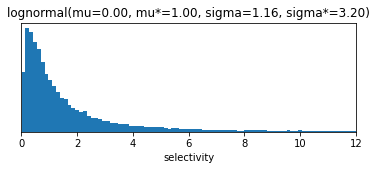

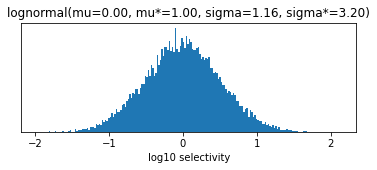

In [170]:
# set distribution for selectivities
mu_star = 1.0
sigma_star = 3.2
mu = np.log(mu_star)
sigma = np.log(sigma_star)

values = rng.lognormal(mu, sigma, 20000)
log10values = np.log10(values)
high = [ i for i in log10values if i >= 1 ]
fraction = len(high)*100/len(values)
print(f"{fraction:.1f}% values above log10=1")

plt.figure(figsize=(6,2))
plt.hist(values, bins=1000)
plt.xlim(0.0,12)
plt.xlabel("selectivity")
plt.yticks([])
plt.title(f"lognormal(mu={mu:.2f}, mu*={mu_star:.2f}, sigma={sigma:.2f}, sigma*={sigma_star:.2f})")
plt.show()

plt.figure(figsize=(6,2))
plt.hist(np.log10(values), bins=200)
#plt.xlim(0.0,12)
plt.xlabel("log10 selectivity")
plt.yticks([])
plt.title(f"lognormal(mu={mu:.2f}, mu*={mu_star:.2f}, sigma={sigma:.2f}, sigma*={sigma_star:.2f})")
plt.show()

mu_selectivity, sigma_selectivity = mu, sigma

7.9% values above log10=1


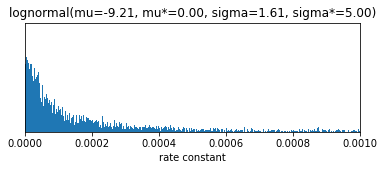

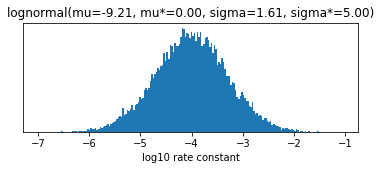

In [204]:
#### set distribution for base rate constants
mu_star = 0.0001
sigma_star = 5#3.25
mu = np.log(mu_star)
sigma = np.log(sigma_star)

values = rng.lognormal(mu, sigma, 20000)
log10values = np.log10(values)
high = [ i for i in log10values if i >= -3 ]
fraction = len(high)*100/len(values)
print(f"{fraction:.1f}% values above log10=1")

plt.figure(figsize=(6,2))
bins = np.linspace(0,0.001,2000)
plt.hist(values, bins=bins)
plt.xlim(0,0.001)

plt.xlabel("rate constant")
plt.yticks([])
plt.title(f"lognormal(mu={mu:.2f}, mu*={mu_star:.2f}, sigma={sigma:.2f}, sigma*={sigma_star:.2f})")
plt.show()

plt.figure(figsize=(6,2))
plt.hist(np.log10(values), bins=200)
#plt.xlim(0.0,12)
plt.xlabel("log10 rate constant")
plt.yticks([])
plt.title(f"lognormal(mu={mu:.2f}, mu*={mu_star:.2f}, sigma={sigma:.2f}, sigma*={sigma_star:.2f})")
plt.show()

mu_base_rate, sigma_base_rate = mu, sigma

In [205]:
# setup sugars
glucose = Species("Glc", "glucose")
mannose = Species("Man", "mannose")
altrose = Species("Alt", "altrose")
allose = Species("All", "allose")
gulose = Species("Gul", "gulose")
galactose = Species("Gal", "galactose")
talose = Species("Tal", "talose")
idose = Species("Ido", "idose")

# must match order in spreadsheet!
sugars = [ glucose, mannose, allose, galactose, altrose, talose, gulose, idose ]
sugars_dict = { s.abbreviation : s for s in sugars }
sugar_abbreviations = [ s.abbreviation for s in sugars ]

# setup catalyst
catalyst_active = Species("cat", "catalyst (active)")
catalyst_dead = Species("dead", "catalyst (dead)")

# these are the network connections
CONNECTIONS = ["Glc_All",  "Glc_Gal",  "Glc_Man",
               "All_Gul",  "Gul_Gal",  "Gal_Tal",
               "Tal_Man",  "Man_Alt",  "Alt_All",
               "Alt_Ido",  "Tal_Ido",  "Ido_Gul"]

In [206]:
def add_connection(reactions_dict, connection_string, base_rate_constant, selectivity):
    sugar1, sugar2 = connection_string.split("_")
    sugar1 = sugars_dict[sugar1]
    sugar2 = sugars_dict[sugar2]

    jk1 = base_rate_constant*sqrt(selectivity)
    jk2 = base_rate_constant/sqrt(selectivity)
    reaction = Reaction({sugar1:1, catalyst_active:1}, {sugar2:1, catalyst_active:1}, reversible=True)
    reactions_dict[reaction] = (jk1,jk2)

In [207]:
def create_network():
    reactions_dict = {}

    for connection in CONNECTIONS:
        random_base_rate = rng.lognormal(mu_base_rate, sigma_base_rate)
        random_selectivity = rng.lognormal(mu_selectivity, sigma_selectivity)
        #base_rate_constant = np.power(10, x[f"{connection}_log10_base_rate_constant"])
        #selectivity = np.power(10, x[f"{connection}_log10_selectivity"])
        add_connection(reactions_dict, connection, random_base_rate, random_selectivity)

    #catalyst_deactivation_reaction = Reaction(catalyst_active, catalyst_dead, reversible=False)
    #reactions_dict[catalyst_deactivation_reaction] = np.power(10.0,x["log10_catalyst_deactivation_rate_constant"])
    
    network = Network(reactions_dict, fixed_concentrations=None)
    return network

In [208]:
# generate times to run simulation over
t_span = (0.0, 1e7)
t_eval = np.logspace(1, 7, num=500, endpoint=True, base=10.0)

In [209]:
def trial():
    network = create_network()

    initial_concentrations_dict = {
        glucose : 0.2,
        catalyst_active : 0.2*0.02,
    }
    concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)
    concentrations_df = concentrations_df*100.0/0.2
    concentrations_df = concentrations_df[["All","Alt","Gal","Glc","Gul","Ido","Man","Tal"]]
    
    # determine max kinetic selectivity
    max_sugar = concentrations_df[["All","Alt","Gal","Gul","Ido","Man","Tal"]].max(axis=0).idxmax()
    max_time = concentrations_df[max_sugar].idxmax()
    kinetics = concentrations_df.loc[max_time].to_numpy()
    thermodynamics = concentrations_df.iloc[-1,:].to_numpy()
    kinetic_selectivities.append(kinetics)
    thermodynamic_selectivities.append(thermodynamics)

In [210]:
kinetic_selectivities = []
thermodynamic_selectivities = []
for i in tqdm(range(2000)):
    trial()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [211]:
kinetic_selectivities = pd.DataFrame(kinetic_selectivities, columns=["All","Alt","Gal","Glc","Gul","Ido","Man","Tal"])
thermodynamic_selectivities = pd.DataFrame(thermodynamic_selectivities, columns=["All","Alt","Gal","Glc","Gul","Ido","Man","Tal"])

In [212]:
maxs = kinetic_selectivities.max(axis=1).to_numpy()
print(f"{(maxs>60).sum() * 100.0 / 2000.0}% values above 60%")

7.75% values above 60%


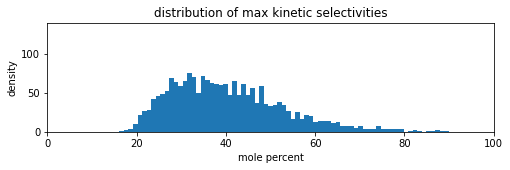

In [213]:
plt.figure(figsize=(8,2))
plt.hist(kinetic_selectivities.max(axis=1),bins=np.linspace(0,100,100))
plt.xlabel("mole percent")
plt.ylabel("density")
plt.xlim(0,100)
plt.ylim(0,140)
plt.title("distribution of max kinetic selectivities")
plt.show()

In [214]:
maxs = thermodynamic_selectivities.max(axis=1).to_numpy()
print(f"{(maxs>60).sum() * 100.0 / 2000.0}% values above 60%")

1.1% values above 60%


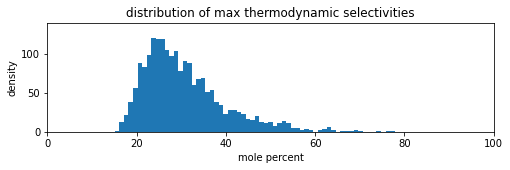

In [215]:
plt.figure(figsize=(8,2))
plt.hist(thermodynamic_selectivities.max(axis=1),bins=np.linspace(0,100,100))
plt.xlabel("mole percent")
plt.ylabel("density")
plt.xlim(0,100)
plt.ylim(0,140)
plt.title("distribution of max thermodynamic selectivities")
plt.show()

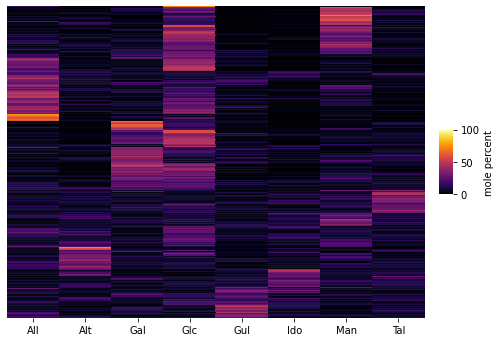

In [203]:
# cbar_pos (left, bottom, width, height)
clustermap = sns.clustermap(kinetic_selectivities, cmap="inferno", vmin=0.0, vmax=100.0, figsize=(8,6),
                            row_cluster=True, col_cluster=False,
                            cbar_pos=(0.95,0.35,0.025,0.15),
                            cbar_kws={'label': 'mole percent'})
clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
clustermap.ax_heatmap.set_yticks([])
plt.show()

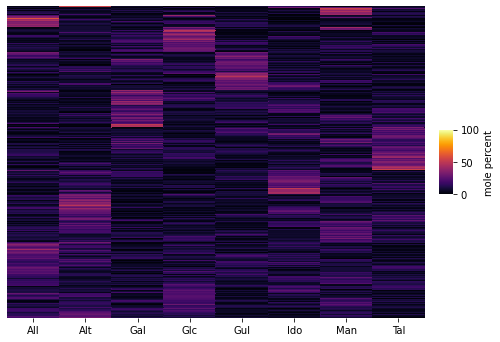

In [202]:
clustermap = sns.clustermap(thermodynamic_selectivities, cmap="inferno", vmin=0.0, vmax=100.0, figsize=(8,6),
                            row_cluster=True, col_cluster=False,
                            cbar_pos=(0.95,0.35,0.025,0.15),
                            cbar_kws={'label': 'mole percent'})
clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
clustermap.ax_heatmap.set_yticks([])
plt.show()

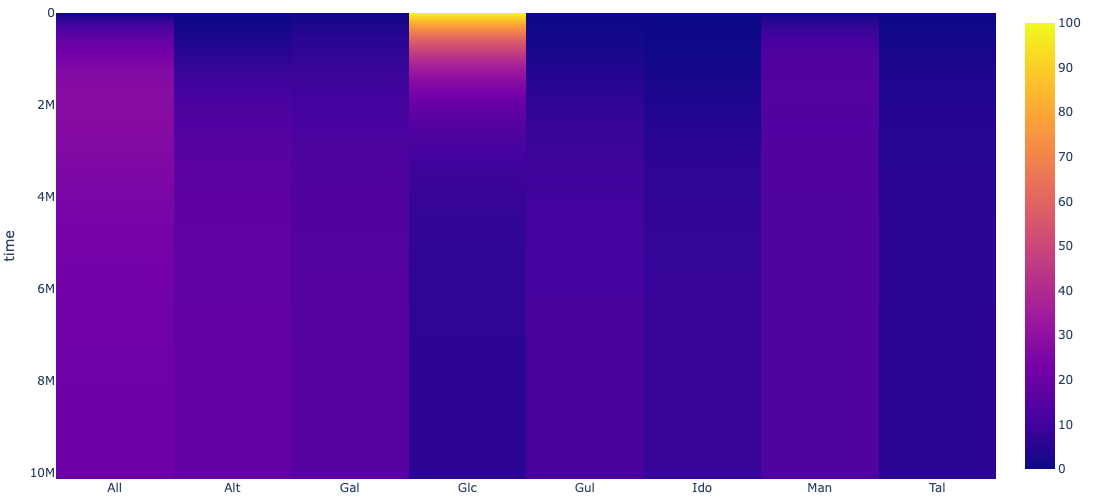

In [58]:
fig = px.imshow(concentrations_df)
fig.update_layout(
    margin = dict(t=5,r=5,b=5,l=5),
    showlegend = False,
    height = 500,
    width = 500,
    autosize = False )
fig.show()